In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-dataset/PNB_5Y.csv
/kaggle/input/bank-dataset/UNIONBANK_5Y.csv
/kaggle/input/bank-dataset/BOI_5Y.csv
/kaggle/input/bank-dataset/SBIN_5Y.csv


In [2]:
df = pd.read_csv("../input/bank-dataset/SBIN_5Y.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-06,197.449997,202.600006,197.100006,198.899994,195.314117,23623536.0
1,2016-06-07,200.449997,211.149994,200.149994,210.149994,206.361298,66063192.0
2,2016-06-08,210.149994,211.899994,207.550003,210.699997,206.901398,35163093.0
3,2016-06-09,210.000000,212.800003,208.300003,209.949997,206.164902,27858182.0
4,2016-06-10,209.350006,211.500000,205.300003,205.949997,202.237015,25598224.0


In [3]:
close = df["Close"]
close.shape
close
close = close.dropna()
close.shape

(1232,)

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
tmp = scaler.fit(np.array(close).reshape(-1,1))
new_df = scaler.transform(np.array(close).reshape(-1,1))

 
print(new_df)

[[0.16637808]
 [0.20533238]
 [0.20723682]
 ...
 [0.99168977]
 [1.        ]
 [0.97905129]]


In [5]:
training_size=int(len(new_df)*0.67)
test_size=len(new_df)-training_size
train_data,test_data=new_df[0:training_size,:],new_df[training_size:len(new_df),:1]

print(train_data.shape)
print(test_data.shape)

(825, 1)
(407, 1)


In [6]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
time_step=100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
#print(X_train, Y_train)

(724, 100) (724,) (306, 100) (306,)


In [8]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print(X_train.shape, X_test.shape)
#print(X_train, Y_train)

(724, 100, 1) (306, 100, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
____________________________________________________

In [10]:
model.fit(X_train,Y_train,validation_data=(X_test, Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 346ms/step - loss: 0.1455 - val_loss: 0.0220
Epoch 2/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0091 - val_loss: 0.0231
Epoch 3/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0055 - val_loss: 0.0244
Epoch 4/100
12/12 [==============================] - 3s 219ms/step - loss: 0.0056 - val_loss: 0.0218
Epoch 5/100
12/12 [==============================] - 3s 219ms/step - loss: 0.0040 - val_loss: 0.0205
Epoch 6/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0039 - val_loss: 0.0188
Epoch 7/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0039 - val_loss: 0.0175
Epoch 8/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0035 - val_loss: 0.0157
Epoch 9/100
12/12 [==============================] - 3s 218ms/step - loss: 0.0035 - val_loss: 0.0144
Epoch 10/100
12/12 [==============================] - 3s 229ms/step - loss: 0.0033 - val_lo

In [11]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
print(train_predict.shape, test_predict.shape)

(724, 1) (306, 1)


In [12]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
print(test_predict)

[[283.22565]
 [276.03903]
 [267.35126]
 [255.09859]
 [246.6704 ]
 [240.32558]
 [234.95216]
 [230.72363]
 [226.53024]
 [223.34389]
 [218.59863]
 [213.25293]
 [208.90013]
 [206.19176]
 [205.2152 ]
 [204.6912 ]
 [205.01988]
 [205.05138]
 [203.69649]
 [202.2322 ]
 [200.86914]
 [200.1242 ]
 [199.63179]
 [199.15964]
 [199.16362]
 [199.9628 ]
 [201.20421]
 [201.84967]
 [202.1076 ]
 [201.97194]
 [201.04013]
 [199.70764]
 [198.6203 ]
 [198.41281]
 [198.9891 ]
 [199.04977]
 [197.81433]
 [195.77515]
 [193.53477]
 [191.25595]
 [189.13274]
 [187.45033]
 [186.75046]
 [186.50075]
 [186.30759]
 [185.3428 ]
 [183.59554]
 [181.53186]
 [179.47716]
 [177.61966]
 [176.11885]
 [175.41019]
 [175.39949]
 [175.9977 ]
 [177.4532 ]
 [179.46106]
 [181.86745]
 [184.2162 ]
 [187.1485 ]
 [190.31847]
 [193.04265]
 [195.26831]
 [196.09798]
 [195.90063]
 [194.77696]
 [193.17398]
 [191.5604 ]
 [190.70116]
 [190.98146]
 [192.34227]
 [194.64774]
 [196.67508]
 [198.03888]
 [198.68762]
 [198.3846 ]
 [197.4066 ]
 [196.6637 ]

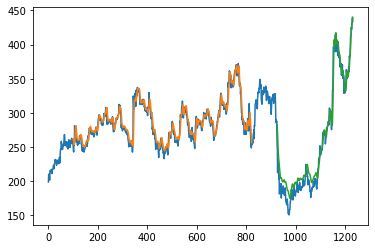

In [13]:
X = scaler.fit_transform(np.array(close).reshape(-1,1))
import matplotlib.pyplot as plt

look_back=100
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(X)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()